## Installing pyTorch and MACE from pip

In [1]:
!pip3 install --upgrade pip

In [2]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
# !pip3 install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124
# !pip3 install pytorch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu126


In [3]:
# Checking pyTorch version
import torch
print(torch.__version__)

2.6.0+cu126


In [4]:
# !pip3 install mace-torch==0.3.10
!pip3 install mace-torch

In [5]:
# Checking MACE version (cuEquivariance depends on the MACE version)
import mace
print(mace.__version__)

0.3.12


In [6]:
# cuequivariance>0.1.0 doesn't work

# !pip3 install cuequivariance==0.1.0 cuequivariance-torch==0.1.0 cuequivariance-ops-torch-cu12==0.1.0
!pip3 install cuequivariance cuequivariance-torch cuequivariance-ops-torch-cu12

In [7]:
!pip list

Package                       Version
----------------------------- --------------
anyio                         4.9.0
argon2-cffi                   23.1.0
argon2-cffi-bindings          21.2.0
arrow                         1.3.0
ase                           3.24.0
asttokens                     3.0.0
async-lru                     2.0.5
attrs                         25.3.0
babel                         2.17.0
beautifulsoup4                4.13.3
biopython                     1.85
bleach                        6.2.0
blinker                       1.9.0
Brotli                        1.1.0
cached-property               1.5.2
certifi                       2025.1.31
cffi                          1.17.1
cftime                        1.6.4
charset-normalizer            3.4.1
click                         8.1.8
colorama                      0.4.6
comm                          0.2.2
ConfigArgParse                1.7
contourpy                     1.3.1
cuequivariance                0.3.0
cuequivar

## Testing MACE+ASE

In [8]:
%cd ase-output

/home/michele/benchmark-mace/ase-output


In [9]:
from ase.io import read, write
from ase import units
from ase.md.velocitydistribution import Stationary, ZeroRotation, MaxwellBoltzmannDistribution

from ase.md.langevin import Langevin

# For some reason these modules are not found:
from ase.md.nose_hoover_chain import NoseHooverChainNVT
from ase.md.bussi import Bussi

import random
import time
import numpy as np

FS2PS = 1e-3
FS2NS = 1e-6
DAY2MIN = 1440

In [10]:
def test_md(init_conf, 
            calc, 
            dyn,
            nsteps=100, 
            fname='md_test.xyz',
            ndump=1):
    
    init_conf.calc = calc
    
    # Remove COM and rotational velocity
    Stationary(init_conf)
    ZeroRotation(init_conf)

    # %matplotlib inline

    time_ps = []
    temperature = []
    energies = []

    def write_frame():
            dyn.atoms.write(fname, append=True)
            time_ps.append(FS2PS*dyn.get_time()/units.fs)
            temperature.append(dyn.atoms.get_temperature())
            energies.append(dyn.atoms.get_potential_energy()/len(dyn.atoms))

    dyn.attach(write_frame, interval=ndump)
    t0 = time.time()
    dyn.run(nsteps)
    t1 = time.time()
    cpu_run_min = (t1-t0)/60
    print("MD finished in {0:.2f} minutes!".format(cpu_run_min))
    print("Estimate: ",FS2NS*DAY2MIN*(nsteps*dt)/cpu_run_min," ns/day")
    
    return time_ps, temperature, energies

In [11]:
# Selecting the MACE model
# from mace.calculators import MACECalculator

# model_file = '/home/michele/lammps-mace/models/mace-mpa-0-medium.model'
# model_file = '/home/michele/lammps-mace/models/2023-12-10-mace-128-L0_energy_epoch-249.model'

# Testing both vanilla and with cuEquivariance 0.1.0
"""
calc_vanilla = MACECalculator(model_paths=model_file, device='cuda', default_dtype="float32")
calc_cuequiv = MACECalculator(model_paths=model_file, device='cuda', default_dtype="float32", enable_cueq=True)
calc_vanilla = MACECalculator(model_paths=model_file, device='cuda', default_dtype="float64")
calc_cuequiv = MACECalculator(model_paths=model_file, device='cuda', default_dtype="float64", enable_cueq=True)
"""

'\ncalc_vanilla = MACECalculator(model_paths=model_file, device=\'cuda\', default_dtype="float32")\ncalc_cuequiv = MACECalculator(model_paths=model_file, device=\'cuda\', default_dtype="float32", enable_cueq=True)\ncalc_vanilla = MACECalculator(model_paths=model_file, device=\'cuda\', default_dtype="float64")\ncalc_cuequiv = MACECalculator(model_paths=model_file, device=\'cuda\', default_dtype="float64", enable_cueq=True)\n'

In [12]:
# Alternative way to define the calculator
from mace.calculators import mace_mp

# calc = mace_mp() # return the default medium ASE calculator equivalent to mace_mp(model="medium")
# calc = mace_mp(model="https://tinyurl.com/y7uhwpje") # downlaod the model at the given url
# calc = mace_mp(dispersion=True) # return a model with D3 dispersion correction

calc_vanilla = mace_mp(model="medium-mpa-0", device='cuda', default_dtype="float64")
calc_cuequiv = mace_mp(model="medium-mpa-0", device='cuda', enable_cueq=True, default_dtype="float64")

/home/michele/mambaforge/envs/benchmark-mace/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


Using medium MPA-0 model as default MACE-MP model, to use previous (before 3.10) default model please specify 'medium' as model argument
Using Materials Project MACE for MACECalculator with /home/michele/.cache/mace/macempa0mediummodel
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/home/michele/mambaforge/envs/benchmark-mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using medium MPA-0 model as default MACE-MP model, to use previous (before 3.10) default model please specify 'medium' as model argument
Using Materials Project MACE for MACECalculator with /home/michele/.cache/mace/macempa0mediummodel
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Converting models to CuEq for acceleration


/home/michele/mambaforge/envs/benchmark-mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/home/michele/mambaforge/envs/benchmark-mace/lib/python3.12/site-packages/mace/modules/models.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "atomic_numbers", torch.tensor(atomic_numbers, dtype=torch.int64)


In [13]:
# A small CoFeNi box 
init_conf = read('../confs/CoFeNi_3.data', '0', format='lammps-data')

In [14]:
# Initializing velocities
seed = 1234
T=300
random.seed(seed)
MaxwellBoltzmannDistribution(init_conf, temperature_K=T)

In [15]:
# Defining the ensemble and propagator(s)
dt=1.0
tdamp_langevin=0.01/units.fs
tdamp_bussi = (1e3)*units.fs
logfile='md_test.log'
# Langevin dynamics
dyn_langevin = Langevin(init_conf, dt*units.fs, temperature_K=T, friction=tdamp_langevin, logfile=logfile)
# Vertlet + Bussi
dyn_bussi = Bussi(init_conf, dt*units.fs, temperature_K=T, taut=tdamp_bussi, logfile=logfile)
# Verlet + Nose-Hoover
dyn_nhc = NoseHooverChainNVT(init_conf, dt*units.fs, temperature_K=T, tdamp=tdamp_bussi, tchain=1, logfile=logfile)

In [16]:
# Run and I/O parameters
nsteps=100
ndump=10

In [17]:
t, T, E = test_md(init_conf, calc_vanilla, dyn=dyn_nhc, nsteps=nsteps, ndump=ndump, fname='md_test_van.xyz')

MD finished in 0.53 minutes!
Estimate:  0.2700516752688283  ns/day


In [18]:
t, T, E = test_md(init_conf, calc_cuequiv, dyn=dyn_nhc, nsteps=nsteps, ndump=ndump, fname='md_test_cue.xyz')

MD finished in 0.12 minutes!
Estimate:  1.250843469508634  ns/day


In [25]:
# Only one repetaion (needs more statistics!)
n_atoms = np.array([108,  256,   500,   864,   1372,  2048 ])
nsday_v = np.array([1.72, 0.703, 0.392, 0.244, 0.155, np.nan])
nsday_c = np.array([1.42, 0.724, 0.384, 0.232, 0.150, 0.093])

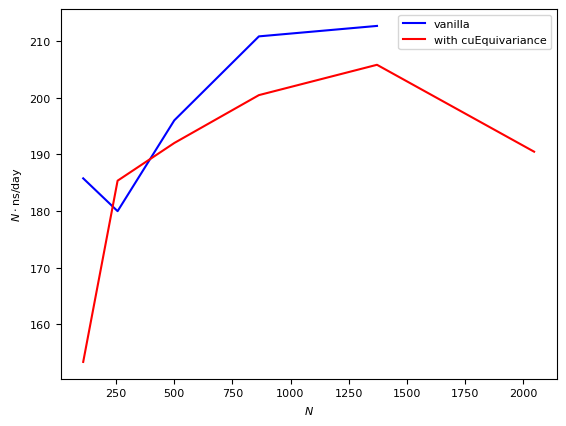

In [26]:
import matplotlib.pyplot as plt
plt.plot(n_atoms, nsday_v*n_atoms, 'b-', label="vanilla")
plt.plot(n_atoms, nsday_c*n_atoms, 'r-', label="with cuEquivariance")
plt.xlabel(r"$N$")
plt.ylabel(r"$N\cdot$ns/day")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


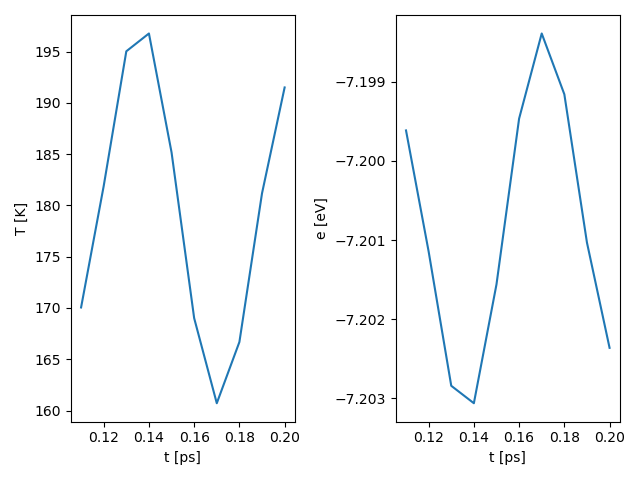

In [20]:
%matplotlib notebook
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(t,T)
ax1.set_xlabel('t [ps]')
ax1.set_ylabel('T [K]')
ax2.plot(t,E)
ax2.set_xlabel('t [ps]')
ax2.set_ylabel('e [eV]')
plt.tight_layout()
plt.show()